In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from dbn.tensorflow import SupervisedDBNClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [42]:
data = pd.read_csv(r'C:\datasets\predictive_maintenance.csv')
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [43]:
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

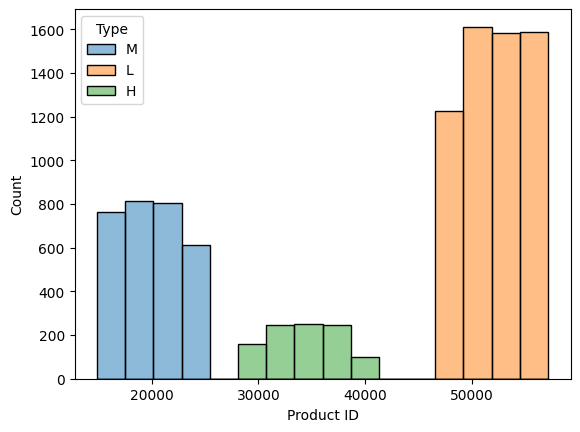

In [44]:
# Remove first character and set to numeric dtype
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

# Histogram of ProductID
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [45]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

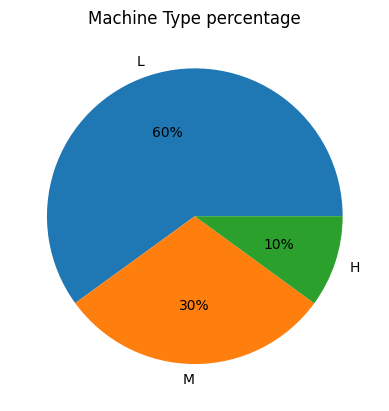

In [48]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

In [49]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [50]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [51]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [53]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)))
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

Global percentage of removed observations: 2700


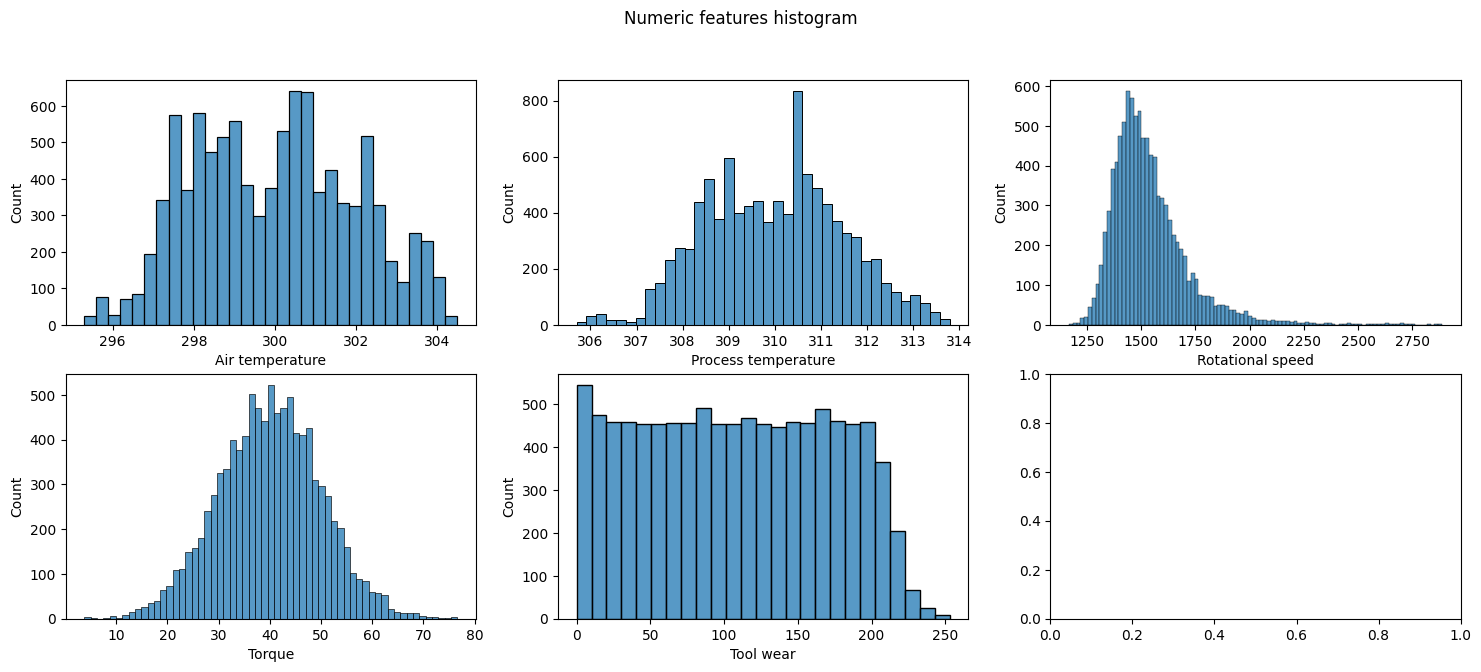

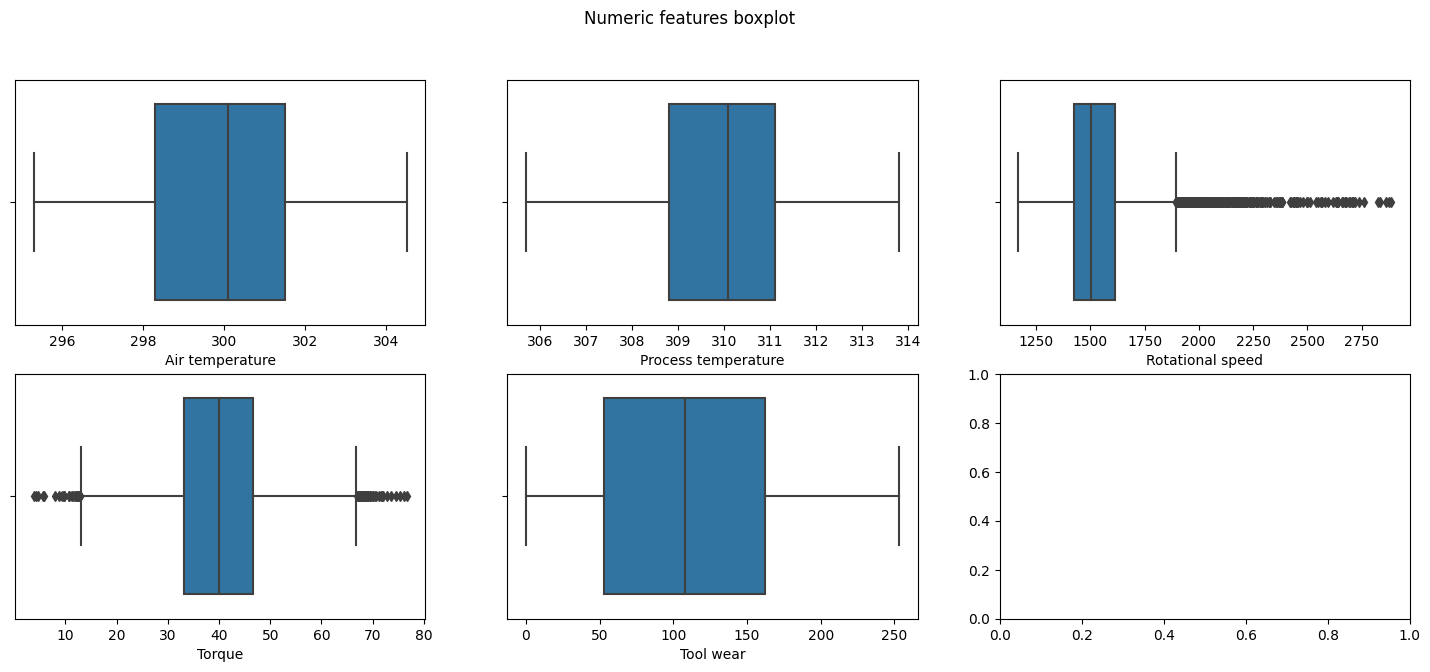

In [54]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

In [17]:
#data = data.drop('Failure Type', axis=1)
data = data.drop('Type', axis=1)


In [18]:
data

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,298.1,308.6,1551,42.8,0,0
1,2,298.2,308.7,1408,46.3,3,0
2,3,298.1,308.5,1498,49.4,5,0
3,4,298.2,308.6,1433,39.5,7,0
4,5,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,9996,298.8,308.4,1604,29.5,14,0
9996,9997,298.9,308.4,1632,31.8,17,0
9997,9998,299.0,308.6,1645,33.4,22,0
9998,9999,299.0,308.7,1408,48.5,25,0


In [19]:
X = np.array(data.drop(["Target"], axis=1))
Y = np.array(data["Target"])

In [56]:
ss=StandardScaler()
X = ss.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.25)
classifier = SupervisedDBNClassification(hidden_layers_structure =[256, 256], learning_rate_rbm=0.05, learning_rate=0.1, n_epochs_rbm=10, n_iter_backprop=100, batch_size=32, activation_function='relu', dropout_p=0.2)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print('nAccuracy of Prediction: %f' % accuracy_score(y_test, y_pred))

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 60.679942
>> Epoch 2 finished 	RBM Reconstruction error 332.901796
>> Epoch 3 finished 	RBM Reconstruction error 1082.697197
>> Epoch 4 finished 	RBM Reconstruction error 2050.724706
>> Epoch 5 finished 	RBM Reconstruction error 3498.415987
>> Epoch 6 finished 	RBM Reconstruction error 5345.880374
>> Epoch 7 finished 	RBM Reconstruction error 6905.137464
>> Epoch 8 finished 	RBM Reconstruction error 8922.688377
>> Epoch 9 finished 	RBM Reconstruction error 12034.162085
>> Epoch 10 finished 	RBM Reconstruction error 16697.776521
>> Epoch 1 finished 	RBM Reconstruction error 4861377919320064.000000
>> Epoch 2 finished 	RBM Reconstruction error 8018472013398016.000000
>> Epoch 3 finished 	RBM Reconstruction error 11247958854991872.000000
>> Epoch 4 finished 	RBM Reconstruction error 12269371871199232.000000
>> Epoch 5 finished 	RBM Reconstruction error 29639107600711680.000000
>> Epoch 6 finished 	RBM Reconstruction 